In [10]:
import logging
import os
import json
import time

import h5py
import numpy as np

from annoy import AnnoyIndex
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Dropout
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

logger = logging.getLogger()
logger.setLevel(logging.INFO)

**So luong hinh su dung de training**

In [8]:
import os

In [9]:
ls_class = os.listdir("/Users/mac/Documents/Machine Learning/Machine Learning Courses/Courses at Vietnam National University/10. Capstone project/Final project/Data/TrainingData")
ls_class.remove('.DS_Store')

ls = []
for i in ls_class:
    path, dirs, files = next(os.walk("/Users/mac/Documents/Machine Learning/Machine Learning Courses/Courses at Vietnam National University/10. Capstone project/Final project/Data/TrainingData"+"/" +i))
    file_count = len(files)
    ls.append([i, file_count])

In [10]:
import pandas as pd
df_class = pd.DataFrame(ls, columns=['class','quantity'])

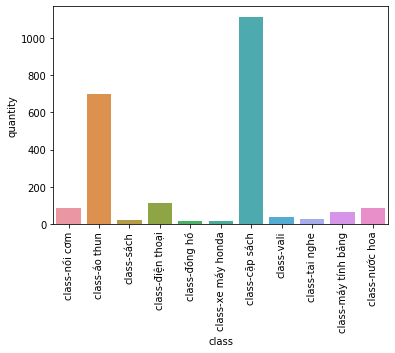

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.barplot(df_class['class'], df_class['quantity'])
plt.xticks(rotation=90)
plt.show()

**Load du lieu**

In [44]:
import os
import numpy as np
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.preprocessing import image


def load_paired_img_wrd(folder):

    class_names = [fold for fold in os.listdir(folder) if ".DS" not in fold]
    image_list = []
    labels_list = []
    paths_list = []
    for cl in class_names:
        splits = cl.split("_")
        
        subfiles = [f for f in os.listdir(folder + "/" + cl) if ".DS" not in f]

        for subf in subfiles:
            full_path = os.path.join(folder, cl, subf)
            img = image.load_img(full_path, target_size=(224, 224))
            x_raw = image.img_to_array(img)
            x_expand = np.expand_dims(x_raw, axis=0)
            x = preprocess_input(x_expand)
            image_list.append(x)
            paths_list.append(full_path)
    img_data = np.array(image_list)
    img_data = np.rollaxis(img_data, 1, 0)
    img_data = img_data[0]

    return img_data, paths_list

In [59]:
path = '/Users/mac/Documents/Machine Learning/Machine Learning Courses/Courses at Vietnam National University/10. Capstone project/Final project/Data/TrainingData'

In [60]:
images, image_paths = load_paired_img_wrd(path)

In [61]:
image_paths[:5]

['/Users/mac/Documents/Machine Learning/Machine Learning Courses/Courses at Vietnam National University/10. Capstone project/Final project/Data/TrainingData/class-nồi cơm/194.jfif',
 '/Users/mac/Documents/Machine Learning/Machine Learning Courses/Courses at Vietnam National University/10. Capstone project/Final project/Data/TrainingData/class-nồi cơm/205.jfif',
 '/Users/mac/Documents/Machine Learning/Machine Learning Courses/Courses at Vietnam National University/10. Capstone project/Final project/Data/TrainingData/class-nồi cơm/497.jfif',
 '/Users/mac/Documents/Machine Learning/Machine Learning Courses/Courses at Vietnam National University/10. Capstone project/Final project/Data/TrainingData/class-nồi cơm/182.jfif',
 '/Users/mac/Documents/Machine Learning/Machine Learning Courses/Courses at Vietnam National University/10. Capstone project/Final project/Data/TrainingData/class-nồi cơm/100.jfif']

**Load pre-trained VGG16 model**

In [48]:
from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Model

def load_headless_pretrained_model():

    pretrained_vgg16 = vgg16.VGG16(weights='imagenet', include_top=True)
    model = Model(inputs=pretrained_vgg16.input,
                  outputs=pretrained_vgg16.get_layer('fc2').output)
    return model

In [49]:
model = load_headless_pretrained_model()

**Sử dụng VGG16 de tao feature va layer gan cuoi cung**

In [50]:
def generate_features(image_paths, model):

    print ("Generating features...")
    start = time.time()
    images = np.zeros(shape=(len(image_paths), 224, 224, 3))
    file_mapping = {i: f for i, f in enumerate(image_paths)}

    
    for i, f in enumerate(image_paths):
        img = image.load_img(f, target_size=(224, 224))
        x_raw = image.img_to_array(img)
        x_expand = np.expand_dims(x_raw, axis=0)
        images[i, :, :, :] = x_expand

    logger.info("%s images loaded" % len(images))
    inputs = preprocess_input(images)
    logger.info("Images preprocessed")
    images_features = model.predict(inputs)
    end = time.time()
    logger.info("Inference done, %s Generation time" % (end - start))
    return images_features, file_mapping

In [67]:
images_features, file_index = generate_features(image_paths, model)

Generating features...


**Luu va tai features de tai su dung**

In [35]:
def save_features(features_filename, features, mapping_filename, file_mapping):

    print ("Saving features...")
    np.save('%s.npy' % features_filename, features)
    with open('%s.json' % mapping_filename, 'w') as index_file:
        json.dump(file_mapping, index_file)
    logger.info("Weights saved")

In [11]:
path1 = '/Users/mac/Documents/Machine Learning/Machine Learning Courses/Courses at Vietnam National University/10. Capstone project/Final project/Code'

In [72]:
save_features(path1, images_features, path1, file_index )

Saving features...


In [12]:
def load_features(features_filename, mapping_filename):

    print ("Loading features...")
    images_features = np.load('%s.npy' % features_filename)
    with open('%s.json' % mapping_filename) as f:
        index_str = json.load(f)
        file_index = {int(k): str(v) for k, v in index_str.items()}
    return images_features, file_index

In [13]:
images_features, file_index = load_features(path1, path1)

Loading features...


**Tao index tu features da co**

In [16]:
def index_features(features, n_trees=1000, dims=4096, is_dict=False):

    print ("Indexing features...")
    feature_index = AnnoyIndex(dims, metric='angular')
    for i, row in enumerate(features):
        vec = row
        if is_dict:
            vec = features[row]
        feature_index.add_item(i, vec)
    feature_index.build(n_trees)
    return feature_index

In [17]:
image_index = index_features(images_features, dims=4096)

Indexing features...


**Su dung key de search index**

In [19]:
def search_index_by_key(key, feature_index, item_mapping, top_n=10):

    distances = feature_index.get_nns_by_item(key, top_n, include_distances=True)
    return [[a, item_mapping[a], distances[1][i]] for i, a in enumerate(distances[0])]

In [20]:
def get_index(input_image, file_mapping):
    for index, file in file_mapping.items():
        if file == input_image:
            return index
    raise ValueError("Image %s not indexed" % input_image)

In [21]:
input_train = '/Users/mac/Documents/Machine Learning/Machine Learning Courses/Courses at Vietnam National University/10. Capstone project/Final project/Data/TrainingData/class-điện thoại/465.jfif'

In [22]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread(input_train)
plt.figure(figsize = (8,8))
plt.imshow(img)
plt.show()

<Figure size 800x800 with 1 Axes>

In [23]:
search_key = get_index(input_train, file_index)

In [25]:
results = search_index_by_key(search_key, image_index, file_index)

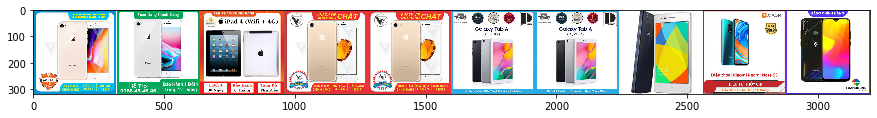

In [27]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
for i in range(len(results)):
    im = results[i][1]
    img=mpimg.imread(im)
    if i==0:
        img_ = img.copy()
    else:
        img_ = np.concatenate((img_,img), axis=1)

plt.figure(figsize=(15,15))
plt.imshow(img_)
plt.show()

**Thay doi weight trong model de tap trung vao vat chinh trong hinh**

In [28]:
def get_class_weights_from_vgg(save_weights=False, filename='class_weights'):

    model_weights_path = os.path.join(os.environ.get('HOME'),
                                      '.keras/models/vgg16_weights_tf_dim_ordering_tf_kernels.h5')
    weights_file = h5py.File(model_weights_path, 'r')
    weights_file.get('predictions').get('predictions_W_1:0')
    final_weights = weights_file.get('predictions').get('predictions_W_1:0')

    class_weights = np.array(final_weights)[:]
    weights_file.close()
    if save_weights:
        np.save('%s.npy' % filename, class_weights)
    return class_weights

In [29]:
def get_weighted_features(class_index, images_features):

    class_weights = get_class_weights_from_vgg()
    target_class_weights = class_weights[:, class_index]
    weighted = images_features * target_class_weights
    return weighted

In [30]:
weighted_features = get_weighted_features(284, images_features)

In [31]:
weighted_index = index_features(weighted_features)

Indexing features...


In [32]:
path2 = '/Users/mac/Documents/Machine Learning/Machine Learning Courses/Courses at Vietnam National University/10. Capstone project/Final project/Report'

In [36]:
save_features(path2, weighted_features, path2, file_index )

Saving features...


In [37]:
weighted_features, file_index = load_features(path2, path2)

Loading features...


In [39]:
weighted_results = search_index_by_key(search_key, weighted_index, file_index)

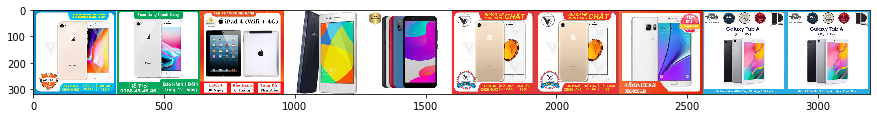

In [40]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
for i in range(len(weighted_results)):
    im = weighted_results[i][1]
    img=mpimg.imread(im)
    if i==0:
        img_ = img.copy()
    else:
        img_ = np.concatenate((img_,img), axis=1)

plt.figure(figsize=(15,15))
plt.imshow(img_)
plt.show()

**Chay model voi testing data**

In [41]:
img_path = '/Users/mac/Documents/Machine Learning/Machine Learning Courses/Courses at Vietnam National University/10. Capstone project/Final project/Data/TestingData'

In [45]:
img, img_paths = load_paired_img_wrd(img_path)

In [51]:
img_features, file_index1 = generate_features(img_paths, model)

Generating features...


In [55]:
a = []
for i in range(len(file_index),len(file_index)+len(file_index1)+1):
    a.append(i)

In [56]:
b = file_index1.values()

In [57]:
dictionary = dict(zip(a,b))

In [72]:
file_index.update(dictionary)

In [60]:
weighted_features1 = get_weighted_features(284, img_features)

weighted_index1 = index_features(weighted_features1)

Indexing features...


In [71]:
vec1 = []

for i in range(201):
    x = weighted_index1.get_item_vector(i)
    vec1.append(x)

In [63]:
for i in range(2263+1,2263+201):
    weighted_index.add_item(i,vec1[i-2264])

In [65]:
# input_path = '/Users/mac/Documents/Machine Learning/Machine Learning Courses/Courses at Vietnam National University/10. Capstone project/Final project/Data/TestingData/class-xe máy honda/59.jfif'

input_path = '/Users/mac/Documents/Machine Learning/Machine Learning Courses/Courses at Vietnam National University/10. Capstone project/Final project/Data/TestingData/class-máy tính bảng/309.jfif'

# input_path = '/Users/mac/Documents/Machine Learning/Machine Learning Courses/Courses at Vietnam National University/10. Capstone project/Final project/Data/TestingData/class-đồng hồ/117.jfif'

# input_path = '/Users/mac/Documents/Machine Learning/Machine Learning Courses/Courses at Vietnam National University/10. Capstone project/Final project/Data/TestingData/class-điện thoại/508.jfif'

In [66]:
search_key1 = get_index(input_path, file_index)

In [68]:
results = search_index_by_key(search_key1, weighted_index, file_index)

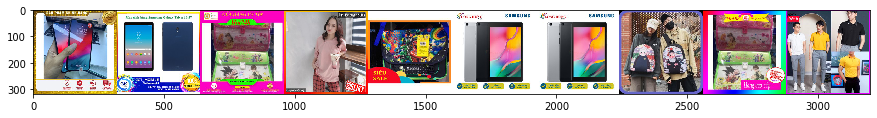

In [70]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
for i in range(len(results)):
    im = results[i][1]
    img=mpimg.imread(im)
    if i==0:
        img_ = img.copy()
    else:
        img_ = np.concatenate((img_,img), axis=1)

plt.figure(figsize=(15,15))
plt.imshow(img_)
plt.show()